## 쇼핑몰  상품 카테고리 분류

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install konlpy
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 3.6MB 38.7MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 18.3MB/s 
     |████████████████████████████████| 450kB 31.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a80c0fb7ff84a04d154e360168e3fd9165de29e7d947c584fea156b68690430f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 

In [0]:
# 필요한 패키지 로드
import numpy as np
import pandas as pd
import random
import pickle
import re
import matplotlib.pyplot as plt
from collections import Counter

from konlpy.tag import Okt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Layer, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

seed = 2020

### 데이터로드

In [0]:
# train_chunk중에 1개만 사용
with open('/content/gdrive/My Drive/이커머스/train_chunk01.txt','rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)
columns = ['pid','product','brand','model','maker','price',
           'bcateid','mcateid','scateid','dcateid']
df = df[columns]
df[['price','bcateid','mcateid','scateid','dcateid']] = df[['price','bcateid','mcateid','scateid','dcateid']].astype('int32')
df[['price','bcateid','mcateid','scateid','dcateid']] = df[['price','bcateid','mcateid','scateid','dcateid']].astype('int32')

### 전처리

In [5]:
# 한글 아닌 데이터 제거
df_pre = df.copy()
df_pre['product'] = df_pre['product'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
df_pre.head()

,pid,product,brand,model,maker,price,bcateid,mcateid,scateid,dcateid
0,b'O4486751463',직소퍼즐 조각 바다거북의 여행,퍼즐라이프,퍼즐라이프 직소퍼즐 바다거북의 여행,상품상세설명 참조,16520,1,1,2,-1
1,b'P3307178849',모리케이스 아이폰 다이어리케이스 바보사랑 ...,바보사랑,아이폰6S/6S+ tree farm101 - 다이어리케이스|아이폰6S/6S+,MORY|해당없음,20370,3,3,4,-1
2,b'R4424255515',크리비아 기모 부 속바지,크리비아,크리비아 기모 3부 속바지 GLG4314P,,-1,5,5,6,-1
3,b'F3334315393',하프클럽 잭앤질 남성 솔리드 절개라인 포인트 포켓 팬츠,잭앤질,[잭앤질] 남성 솔리드 절개라인 포인트 포켓 팬츠 31133PT002_NA,㈜크리스패션,16280,7,7,8,-1
4,b'N731678492',코드프리혈당시험지 매 코드프리시험지 최장유효기간,,SD코드프리혈당시험지[50매],기타,-1,10,9,11,-1


In [6]:
# 데이터중 상품명만 사용
corpus = df_pre['product'].tolist()
print(f'corpus size : {len(corpus)}')

corpus size : 1000000


In [0]:
# okt 형태소 분석기
okt = Okt()

In [8]:
# 상품명을 형태소 분석
tokenized_morphs = [okt.morphs(sentence, stem=True) for sentence in corpus]
len(tokenized_morphs)

1000000

In [29]:
# 단어의 개수
counter = Counter()
for i in tokenized_morphs:
    counter.update(Counter(i))
print("사용된 단어의 개수 %d" %len(counter))

사용된 단어의 개수 59500


In [0]:
# 35000개 단어만 사용
max_words = 35000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(tokenized_morphs)

In [0]:
# 중카테고리를 분류
train = tokenizer.texts_to_sequences(tokenized_morphs)
mcate = df['mcateid'].values

상품명의 최대 길이 : 51
상품명의 평균 길이 : 8.187812


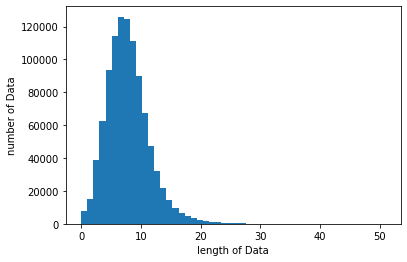

In [32]:
# 상품명의 길이분포 시각화
print('상품명의 최대 길이 :',max(len(l) for l in train))
print('상품명의 평균 길이 :',sum(map(len, train))/len(train))
plt.hist([len(s) for s in train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [0]:
# 길이가 25로 패딩
max_len=25
train = pad_sequences(train, maxlen=max_len)
y_len = len(df['mcateid'].unique())

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(train,mcate,test_size = 0.2,random_state = seed)

In [13]:
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(800000, 25) (200000, 25) (800000,) (200000,)


## 어텐션 모델 구현

In [0]:
# LSTM의 hidden state를 query
# LSTM의 output을 key와 value

class MyAttention(Layer):

    def __init__(self, **kwargs):
        super(MyAttention, self).__init__()

    def call(self, query, values):
        # query shape = (None, 128)
        hidden_query = tf.expand_dims(query, 1) # 연산을 위해 (None, 1, 128) shape로 바꿔줌
        
        hidden_layer = tf.matmul(hidden_query, values, transpose_b = True) # dot product, shape = (None,1,25)

        attention = tf.nn.softmax(hidden_layer) # softmax함수

        attention_distribution = Permute((2,1))(attention) # shape = (None, 25, 1)

        attention_value = attention_distribution * values # 어텐션 분포와 value 곱함, shape = (None, 25, 128)
        attention_value = tf.reduce_sum(attention_value, axis = 1) # 어텐션 값을 더함, shape = (None, 128)

        return attention_value, attention_distribution

In [15]:
# 모델 구현

inp = Input(shape = (max_len,))
embed = Embedding(max_words, 128)(inp) # 임베딩
lstm_layer1 = LSTM(128, return_sequences=True, return_state=True)
#lstm_output shape = (None, 25, 128), state_h shape = (None,128)
lstm_output, state_h, _ = lstm_layer1(embed) # key(value), query

my_attention = MyAttention()
attention_value, attention_distribution = my_attention(state_h, lstm_output)

output = Dense(y_len+1, activation = 'softmax')(attention_value)

model = Model(inputs = inp, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 128)           4480000   
_________________________________________________________________
lstm (LSTM)                  [(None, 25, 128), (None,  131584    
_________________________________________________________________
my_attention (MyAttention)   ((None, 128), (None, 25,  0         
_________________________________________________________________
dense (Dense)                (None, 464)               59856     
Total params: 4,671,440
Trainable params: 4,671,440
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 5번 학습
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_train, Y_train, epochs=5, batch_size=60, validation_split=0.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/5
640000/640000 [==============================] - 857s 1ms/sample - loss: 0.9031 - acc: 0.8053 - val_loss: 0.4409 - val_acc: 0.8888
Epoch 2/5
640000/640000 [==============================] - 814s 1ms/sample - loss: 0.3457 - acc: 0.9087 - val_loss: 0.3755 - val_acc: 0.9025
Epoch 3/5
640000/640000 [==============================] - 768s 1ms/sample - loss: 0.2659 - acc: 0.9264 - val_loss: 0.3578 - val_acc: 0.9082
Epoch 4/5
640000/640000 [==============================] - 781s 1ms/sample - loss: 0.2190 - acc: 0.9378 - val_loss: 0.3569 - val_acc: 0.9096
Epoch 5/5
640000/640000 [==============================] - 782s 1ms/sample - loss: 0.1873 - acc: 0.9461 - val_loss: 0.3523 - val_acc: 0.9126


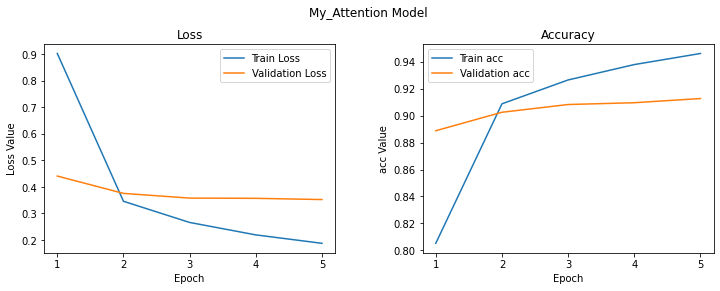

In [21]:
# loss, accuracy 시각화
epochs = len(history.history['loss'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('My_Attention Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['loss'], label='Train Loss')
ax1.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(1, epochs+1))
ax1.set_ylabel('Loss Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Loss')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['acc'], label='Train acc')
ax2.plot(epoch_list, history.history['val_acc'], label='Validation acc')
ax2.set_xticks(np.arange(1, epochs+1))
ax2.set_ylabel('acc Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Accuracy')
l2 = ax2.legend(loc="best")

In [23]:
# validation data로 정확도 체크
print('테스트 정확도 : %lf' %(model.evaluate(X_val,Y_val)[1]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



테스트 정확도 : 0.912280


In [0]:
model.save('my_attention.hdf5')